# 모델을 만들기 위한 절차

1. 2개 이상의 데이터가 들어오면 자동으로 처리할 수 있게 해주는 모델 개발
2. 현재는 4개의 데이터를 직접 전처리해 한개의 데이터를 추출할 수 있게 해놓음
3. 기온과 습도 풍향과 풍속은 그날 바로 알 수 있으므로, 이 4개 데이터를 넣으면 그 지역 현재 시간대의 미세먼지 등급을 알 수 있게 하는 모델

결론적으로 처리할 건  
(이렇게 하려면 실시간으로 데이터를 크롤링 해와 데이터를 쉽게 다룰 수 있도록 바꾸는 과정이 필요함. -> 현재 불가)  
(그냥 과거 데이터를 그냥 두고, 입력을 4개하면 그 지역 미세먼지 등급을 예측하는 모델을 생각해보자.)  
input : 입력하세요 -> 기온, 습도, 풍향, 풍속, 위도(거의 비슷한 위치이므로 생략), 경도(거의 비슷한 위치이므로 생략)  
처리중입니다. -> 결과 : **지역 미세먼지 등급 - 좋음



다음에 해야할 작업 - >
1. 위도, 경도 데이터를 대안동을 뺀 나머지 데이터에 다 넣어주고,
2. 위도, 경도, 풍향, 풍속, 기온, 습도 6가지 데이터의 특징을 찾아보고 (없을 확률이 높다)  

-> 한개지역의 데이터씩 뽑아서 <올라가거나 내려가는 구간>에서는 회귀분석을 통해, 나온 예측값들을 조화평균내서 대안동에 대입하고, 거의 일정한 구간에서는 그 값들의 평균을 내 대안동에 대입해서 pm25를 예측하는 알고리즘을 만들어서 만들고, 그 값들을 SVM, KNN 등등에 대입해 4가지 등급을 예측하는 알고리즘을 만들자 


-> 올라가거나 내려가는 구간을 판별하는 방식은 경사하강법? 미분을 적용시켜 속도가 변하는 구간이 발생하는 조건을 넣어서 생기는 구간을 만들면 되지 않을까 생각한다.

## 해야할 목표
1. 나쁨과 보통의 기준을 나눠 아림 데이터의 나쁨을 잘 나타낼 수 있는 방향성을 찾기 16 ~ 35,36 ~ 75
    - 나쁨과 보통 기준 데이터만 모아서 아림과 airKorea의 데이터 차이를 한번 비교해보기 ( 일단 해봐야 알 것 같다 )
2. PM2.5를 예측할 수 있게 데이터를 조작해보기 ( 이것도 일단 해봐야 알 것 같다 )

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import timedelta, datetime
from matplotlib import font_manager, rc
from matplotlib.ticker import MaxNLocator

from IPython.display import Image # 이미지 삽입

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['figure.figsize'] = [25,15]
plt.rcParams['font.size'] = 25

In [28]:
# outliar 제거 함수 (IQR 설정)
def remove_out(*dataframes, remove_col) :
    for i, dataframe in enumerate(dataframes) :
        for k in remove_col :
            level_1q = dataframe[k].quantile(0.25)
            level_3q = dataframe[k].quantile(0.75)
            IQR = level_3q - level_1q
            rev_range = 10
            
            outliar_h = dataframe[k] >= level_3q + (rev_range * IQR)
            outliar_l = dataframe[k] <= level_1q - (rev_range * IQR)

            a=dataframe[outliar_h].index
            b=dataframe[outliar_l].index
            
            print(dataframe.name,":",[a,b],"\n")
            
            dataframe.drop(a, inplace=True)
            dataframe.drop(b, inplace=True)

# 풍향과 풍속을 풍벡터로 표현
def wind_vector(*dataframe):
    for data in dataframe :
        # 풍향을 라디안으로 변환
        theta = np.deg2rad(data.wind_dir)

        # 극 좌표에서 직교 좌표로 변환
        x = data.wind_speed * np.cos(theta)
        y = data.wind_speed * np.sin(theta)

        data['wind_vector_x'] = x
        data['wind_vector_y'] = y
        data.drop('wind_dir', axis=1, inplace=True)
        data.drop('wind_speed', axis=1, inplace=True)

#그래프 2개 비교 (차이 비교) -- 숫자를 표시안함
def difference(dataframe1, dataframe2) :    
    diff = np.subtract(dataframe1,dataframe2)
    
    # diff가 0보다 작은 index 찾는 것
    diff_down = dataframe2.loc[diff.loc[diff < 0].index]
    display(diff_down.index)
    
    # diff의 값을 평균내는 부분
    print(diff.describe())
    
    # 20%인 위치 값 찾기
    try :
        sorted_diff = diff.sort_values()
        ten_percent_index = int(len(sorted_diff) * 0.1)
        ten_percent_value = sorted_diff.iloc[ten_percent_index]
        print("10% value: ", ten_percent_value)
    except IndexError as e:
        if "single positional indexer is out-of-bounds" in str(e):
            print("매우나쁨 농도가 없습니다.")
        else:
            raise e
    finally :
        # 숫자 넣는 부분, height + 0.25로 숫자 약간 위로 위치하게 조정
        plt.plot(dataframe1.index,diff)
        for i in range(len(dataframe1.index)):
            height = diff[i]
            plt.text(dataframe1.index[i], height + 0.01, '%.2f' %height, ha='center', va='bottom', size = 25)
        plt.title("Difference between airm-airKorea")
        plt.xlabel("Hour")
        plt.ylabel("diff")
        plt.show()
    
# # 아림의 미세먼지 농도가 매우나쁨 이상일 때, airKorea의 미세먼지 농도의 평가
# def air_quality_label(pm25):
#     if pm25 <= 15:
#         return '좋음'
#     elif pm25 <= 35:
#         return '보통'
#     elif pm25 <= 75:
#         return '나쁨'
#     else:
#         return '매우 나쁨'
    
# 미세먼지 농도 라벨 설정
def air_quality_label(pm25):
    if pm25 <= 35:
        return '좋음,보통'
    else:
        return '나쁨,매우 나쁨'

- 2개의 데이터를 가져와서 대안동을 예측해보자

In [ ]:
# arim_data 12.1~12.15 Hour
OA200_2 = pd.read_csv('./OA200_2/OA2002_12.01~12.15.csv')
OA200_2['reg_date'] = OA200_2.reg_date.apply(pd.to_datetime)

OA200_1 = pd.read_csv('./OA200_1/OA2001_12.01~12.15.csv')
OA200_1['reg_date'] = OA200_1.reg_date.apply(pd.to_datetime)

# airKorea_data 1.1~1.15 Hour, 상봉동 : 1, 상대동 : 2, 대안동 : 3
airKorea_data_1 = pd.read_csv('./AirKorea_상봉동/AirKorea_01.01~01.15.csv')
airKorea_data_1['date'] = airKorea_data_1.date.apply(pd.to_datetime)

airKorea_data_2 = pd.read_csv('./AirKorea_상대동/AirKorea_01.01~01.15.csv')
airKorea_data_2['date'] = airKorea_data_2.date.apply(pd.to_datetime)

airKorea_data_3 = pd.read_csv('./AirKorea_대안동/AirKorea_01.01~01.15.csv')
airKorea_data_3['date'] = airKorea_data_3.date.apply(pd.to_datetime)



In [1]:
# 현재 할 수 있는 것은 과거 15일치의 데이터를 보고 pm25를 예측해서 knn이나 다른 알고리즘을 적용해 좋음, 보통, 나쁨, 매우나쁨을 판단하는 것
# 그렇지만, 데이터를 확인해봤을 때, 좋음,보통은 잘 구별하기가 힘드니, 보통과 좋음을 같은고리에 두고, 나쁨과 매우나쁨을 같은 고리에 두어 모델을 판단

def model()

SyntaxError: expected ':' (3110346770.py, line 4)

학교 : [Int64Index([], dtype='int64'), Int64Index([], dtype='int64')] 

진주성 : [Int64Index([12405], dtype='int64'), Int64Index([], dtype='int64')] 

상봉동 : [Int64Index([], dtype='int64'), Int64Index([], dtype='int64')] 

상대동 : [Int64Index([], dtype='int64'), Int64Index([], dtype='int64')] 

대안동 : [Int64Index([], dtype='int64'), Int64Index([], dtype='int64')] 



C:\Users\ASUS\AppData\Local\Temp\ipykernel_10404\273457988.py:29: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  OA200_2_avg = OA200_2.groupby([pd.Grouper(key='reg_date', freq='H')]).mean()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_10404\273457988.py:30: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  OA200_1_avg = OA200_1.groupby([pd.Grouper(key='reg_date', freq='H')]).mean()


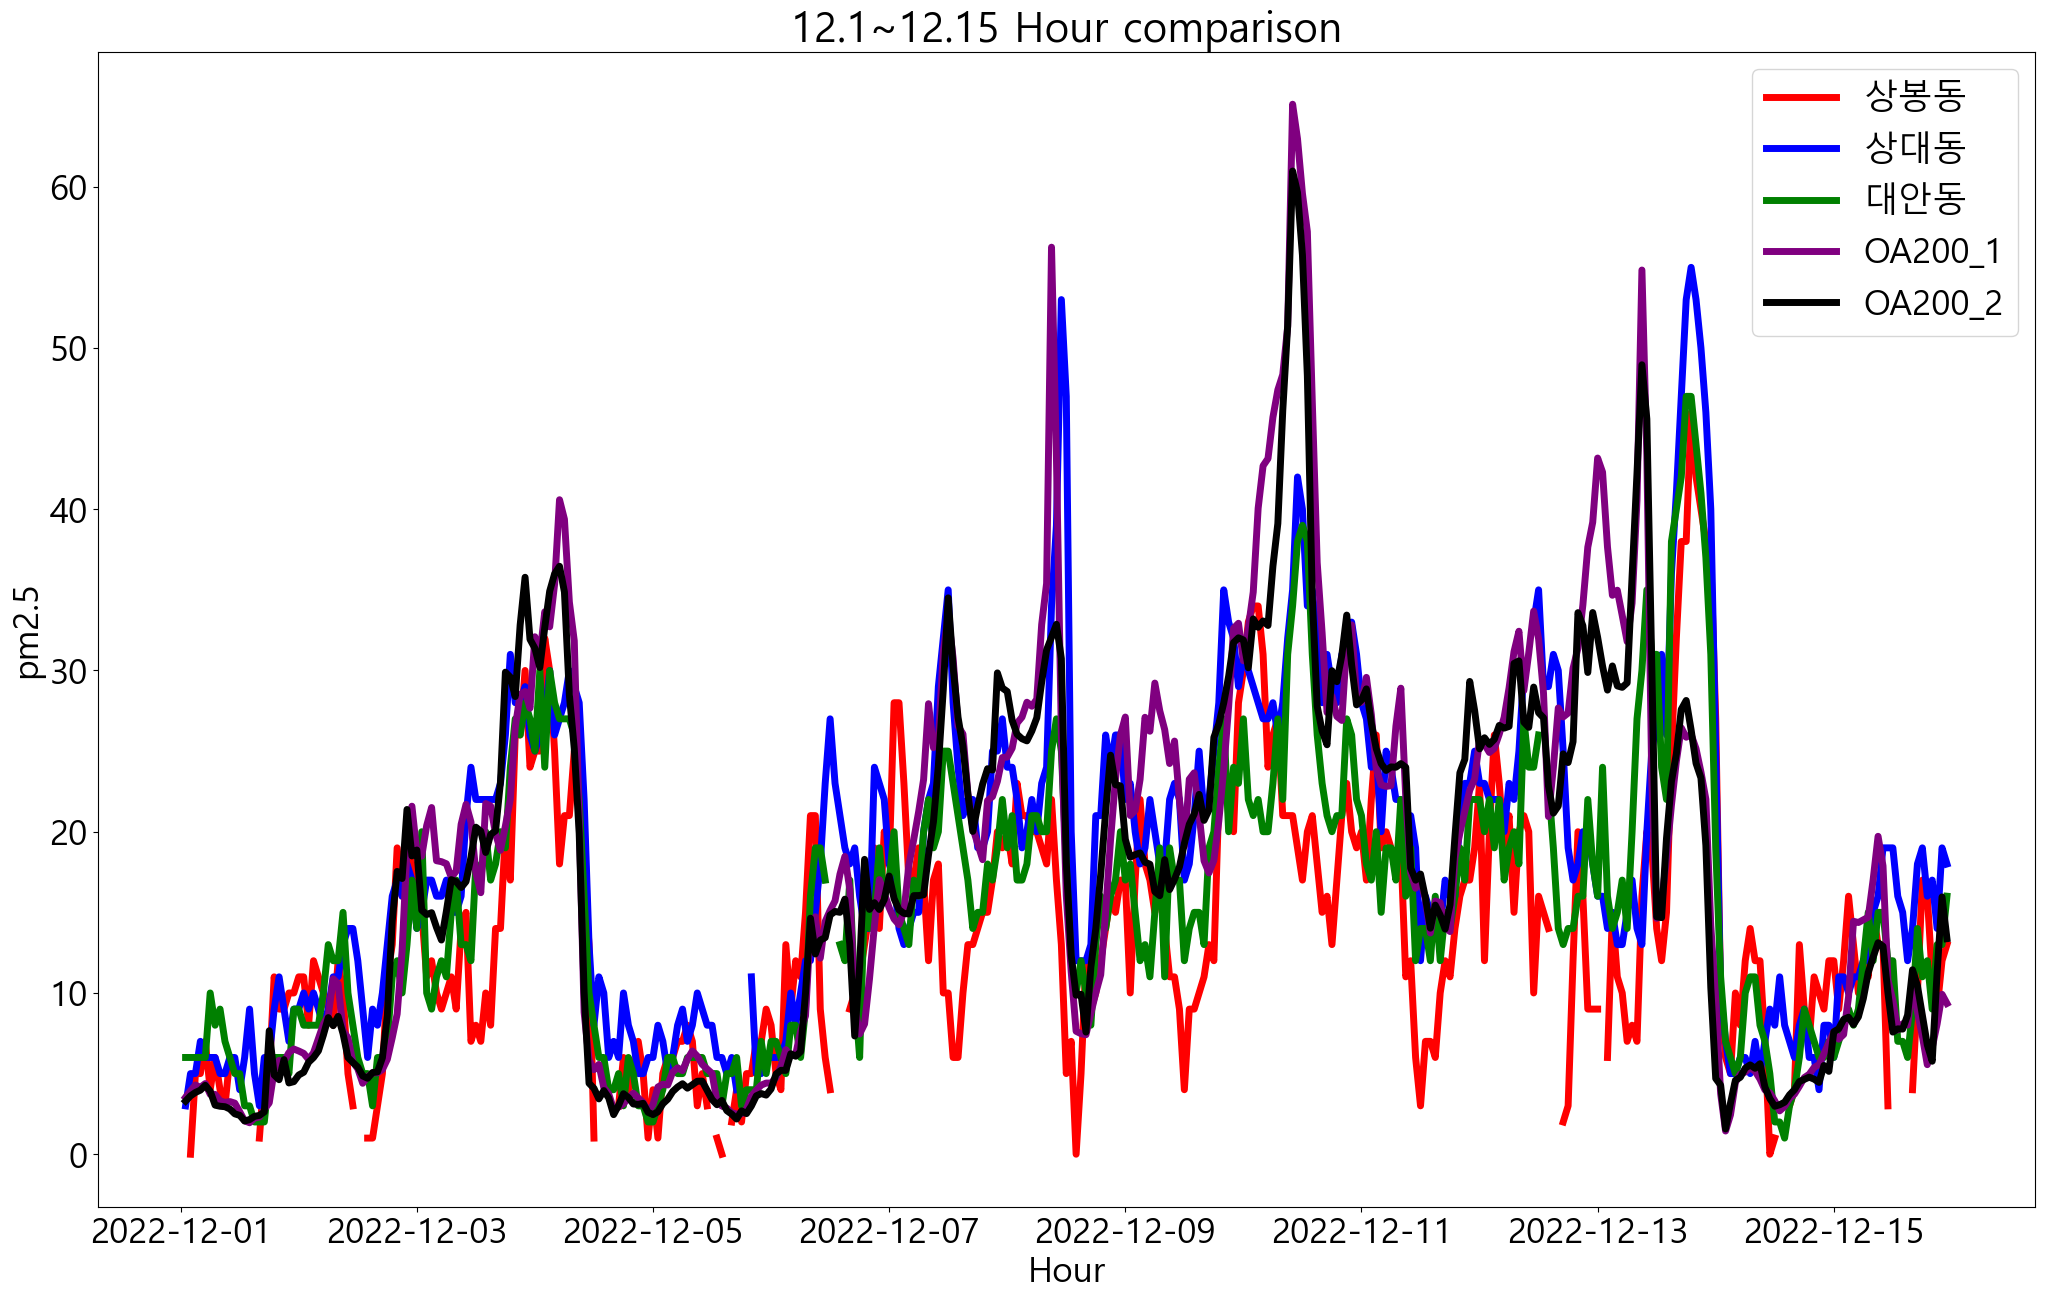

In [11]:
# arim_data 12.1~12.15 Hour
OA200_2 = pd.read_csv('./OA200_2/OA2002_12.01~12.15.csv')
OA200_2['reg_date'] = OA200_2.reg_date.apply(pd.to_datetime)

OA200_1 = pd.read_csv('./OA200_1/OA2001_12.01~12.15.csv')
OA200_1['reg_date'] = OA200_1.reg_date.apply(pd.to_datetime)

# airKorea_data 12.1~12.15 Hour, 상봉동 : 1, 상대동 : 2, 대안동 : 3
airKorea_data_1 = pd.read_csv('./AirKorea_상봉동/AirKorea_12.01~12.15.csv')
airKorea_data_1['date'] = airKorea_data_1.date.apply(pd.to_datetime)

airKorea_data_2 = pd.read_csv('./AirKorea_상대동/AirKorea_12.01~12.15.csv')
airKorea_data_2['date'] = airKorea_data_2.date.apply(pd.to_datetime)

airKorea_data_3 = pd.read_csv('./AirKorea_대안동/AirKorea_12.01~12.15.csv')
airKorea_data_3['date'] = airKorea_data_3.date.apply(pd.to_datetime)

# 이름 설정
OA200_1.name = '학교'
OA200_2.name = '진주성'
airKorea_data_1.name = '상봉동'
airKorea_data_2.name = '상대동'
airKorea_data_3.name = '대안동'

# outliar 제거
remove_out(OA200_1, OA200_2, airKorea_data_1, airKorea_data_2, airKorea_data_3, ['pm25'])

# 1시간 단위로 측정 나누기
OA200_2_avg = OA200_2.groupby([pd.Grouper(key='reg_date', freq='H')]).mean()
OA200_1_avg = OA200_1.groupby([pd.Grouper(key='reg_date', freq='H')]).mean()
airKorea_data_1_avg = airKorea_data_1.groupby([pd.Grouper(key='date', freq='H')]).mean()
airKorea_data_2_avg = airKorea_data_2.groupby([pd.Grouper(key='date', freq='H')]).mean()
airKorea_data_3_avg = airKorea_data_3.groupby([pd.Grouper(key='date', freq='H')]).mean()

# 그래프 5개 비교
plt.plot(airKorea_data_1_avg.index, airKorea_data_1_avg.pm25, color="red", linewidth="5")
plt.plot(airKorea_data_2_avg.index, airKorea_data_2_avg.pm25, color="blue", linewidth="5")
plt.plot(airKorea_data_3_avg.index, airKorea_data_3_avg.pm25, color='green', linewidth="5")
plt.plot(OA200_1_avg.index, OA200_1_avg.pm25, color='purple', linewidth="5")
plt.plot(OA200_2_avg.index, OA200_2_avg.pm25, color='black', linewidth="5")
plt.xlabel('Hour')
plt.ylabel('pm2.5')
plt.legend(('상봉동','상대동','대안동','OA200_1','OA200_2'))
plt.title('12.1~12.15 Hour comparison')
plt.show()

In [33]:
# arim_data 1.01~1.15 Hour
OA200_2 = pd.read_csv('./OA200_2/OA2002_12.01~12.15.csv')
OA200_2['reg_date'] = OA200_2.reg_date.apply(pd.to_datetime)

OA200_1 = pd.read_csv('./OA200_1/OA2001_12.01~12.15.csv')
OA200_1['reg_date'] = OA200_1.reg_date.apply(pd.to_datetime)

# airKorea_data 1.16~1.31 Hour, 상봉동 : 1, 상대동 : 2, 대안동 : 3
airKorea_data_1 = pd.read_csv('./AirKorea_상봉동/AirKorea_12.01~12.15.csv')
airKorea_data_1['date'] = airKorea_data_1.date.apply(pd.to_datetime)

airKorea_data_2 = pd.read_csv('./AirKorea_상대동/AirKorea_12.01~12.15.csv')
airKorea_data_2['date'] = airKorea_data_2.date.apply(pd.to_datetime)

airKorea_data_3 = pd.read_csv('./AirKorea_대안동/AirKorea_12.01~12.15.csv')
airKorea_data_3['date'] = airKorea_data_3.date.apply(pd.to_datetime)

# 이름 설정
OA200_1.name = '학교'
OA200_2.name = '진주성'
airKorea_data_1.name = '상봉동'
airKorea_data_2.name = '상대동'
airKorea_data_3.name = '대안동'

# outliar 제거
remove_out(OA200_1, OA200_2, airKorea_data_1, airKorea_data_2, airKorea_data_3, remove_col=['pm25'])

# 1시간 단위로 측정 나누기
OA200_2_avg = OA200_2.groupby([pd.Grouper(key='reg_date', freq='H')]).mean()
OA200_1_avg = OA200_1.groupby([pd.Grouper(key='reg_date', freq='H')]).mean()
airKorea_data_1_avg = airKorea_data_1.groupby([pd.Grouper(key='date', freq='H')]).mean()
airKorea_data_2_avg = airKorea_data_2.groupby([pd.Grouper(key='date', freq='H')]).mean()
airKorea_data_3_avg = airKorea_data_3.groupby([pd.Grouper(key='date', freq='H')]).mean()

# arim 데이터 수정
OA200_1_avg_76 = OA200_1_avg.loc[OA200_1_avg.loc[OA200_1_avg.pm25 >= 76].index]
OA200_2_avg_76 = OA200_2_avg.loc[OA200_2_avg.loc[OA200_2_avg.pm25 >= 76].index]
OA200_1_avg_76.pm25 -= 10.65
OA200_2_avg_76.pm25 -= 10.65

# arim 데이터 수정 후 대입
OA200_1_avg.loc[OA200_1_avg_76.index, 'pm25'] = OA200_1_avg_76['pm25']
OA200_2_avg.loc[OA200_2_avg_76.index, 'pm25'] = OA200_2_avg_76['pm25']

# 좋음, 보통, 나쁨, 매우나쁨 카데고리 분류
OA200_1_avg['air_quality_label'] = OA200_1_avg['pm25'].apply(lambda x: air_quality_label(x))
OA200_2_avg['air_quality_label'] = OA200_2_avg['pm25'].apply(lambda x: air_quality_label(x))
airKorea_data_1_avg['air_quality_label'] = airKorea_data_1_avg['pm25'].apply(lambda x: air_quality_label(x))
airKorea_data_2_avg['air_quality_label'] = airKorea_data_2_avg['pm25'].apply(lambda x: air_quality_label(x))
airKorea_data_3_avg['air_quality_label'] = airKorea_data_3_avg['pm25'].apply(lambda x: air_quality_label(x))

# arim 데이터 풍향, 풍속 데이터 삽입
Sangbong = pd.read_csv("./weather/상봉동/2022-12.csv", encoding='cp949')
Sangbong['일시'] = Sangbong['일시'].apply(pd.to_datetime)
Sangbong_avg = Sangbong.groupby([pd.Grouper(key='일시', freq='H')]).mean()
OA200_2_avg['wind_dir'] = Sangbong_avg['풍향(16방위)']
OA200_2_avg['wind_speed'] = Sangbong_avg['풍속(m/s)']

Jungchon = pd.read_csv("./weather/정촌면(학교근처)/2022-12.csv", encoding='cp949')
Jungchon['일시'] = Jungchon['일시'].apply(pd.to_datetime)
Jungchon_avg = Jungchon.groupby([pd.Grouper(key='일시', freq='H')]).mean()
OA200_1_avg['wind_dir'] = Jungchon_avg['풍향(16방위)']
OA200_1_avg['wind_speed'] = Jungchon_avg['풍속(m/s)']

# airKorea 데이터 온도, 습도, 풍향, 풍속 데이터 삽입
airKorea_data_1_avg['temp'] = Sangbong_avg['기온']
airKorea_data_1_avg['humi'] = Sangbong_avg['상대습도(%)']
airKorea_data_1_avg['wind_dir'] = Sangbong_avg['풍향(16방위)']
airKorea_data_1_avg['wind_speed'] = Sangbong_avg['풍속(m/s)']

Sangdae = pd.read_csv("./weather/상대동/2022-12.csv", encoding='cp949')
Sangdae['일시'] = Sangdae['일시'].apply(pd.to_datetime)
Sangdae_avg = Sangdae.groupby([pd.Grouper(key='일시', freq='H')]).mean()
airKorea_data_2_avg['temp'] = Sangdae_avg['기온']
airKorea_data_2_avg['humi'] = Sangdae_avg['상대습도(%)']
airKorea_data_2_avg['wind_dir'] = Sangdae_avg['풍향(16방위)']
airKorea_data_2_avg['wind_speed'] = Sangdae_avg['풍속(m/s)']

Daean = pd.read_csv("./weather/대안동/2022-12.csv", encoding='cp949')
Daean['일시'] = Daean['일시'].apply(pd.to_datetime)
Daean_avg = Daean.groupby([pd.Grouper(key='일시', freq='H')]).mean()
airKorea_data_3_avg['temp'] = Daean_avg['기온']
airKorea_data_3_avg['humi'] = Daean_avg['상대습도(%)']
airKorea_data_3_avg['wind_dir'] = Daean_avg['풍향(16방위)']
airKorea_data_3_avg['wind_speed'] = Daean_avg['풍속(m/s)']

# OA200 데이터의 필요없는 no 열 삭제
OA200_1_avg = OA200_1_avg.drop('no', axis=1)
OA200_2_avg = OA200_2_avg.drop('no', axis=1)

# 일단 데이터 셋 확인
display(OA200_1_avg.info())
display(OA200_2_avg.info())
display(airKorea_data_1_avg.info())
display(airKorea_data_2_avg.info())
display(airKorea_data_3_avg.info())

# 참고로 Nan 값을 가진 대안동의 데이터를 소거 해주는 작업이 필요!
airKorea_data_1_avg = airKorea_data_1_avg.dropna(subset=['pm25'], axis=0)
airKorea_data_2_avg = airKorea_data_2_avg.dropna(subset=['pm25'], axis=0)
airKorea_data_3_avg = airKorea_data_3_avg.dropna(subset=['pm25'], axis=0)
OA200_1_avg = OA200_1_avg.dropna(subset=['pm25'], axis=0)
OA200_2_avg = OA200_2_avg.dropna(subset=['pm25'], axis=0)

# 가장 작은 airKorea_data의 인덱스와 나머지 데이터들의 인덱스 같게 만들어주기
idx = set(airKorea_data_1_avg.index).intersection(
    set(airKorea_data_2_avg.index),
    set(airKorea_data_3_avg.index),
    set(OA200_1_avg.index),
    set(OA200_2_avg.index)
)
airKorea_data_1_avg = airKorea_data_1_avg.reindex(idx)
airKorea_data_2_avg = airKorea_data_2_avg.reindex(idx)
airKorea_data_3_avg = airKorea_data_3_avg.reindex(idx)
OA200_1_avg = OA200_1_avg.reindex(idx)
OA200_2_avg = OA200_2_avg.reindex(idx)

# 수정 후 데이터 셋 확인
print("###################################\n"*5)
print("수정후")

# 풍벡터 삽입
wind_vector(OA200_1_avg, OA200_2_avg, airKorea_data_1_avg, airKorea_data_2_avg, airKorea_data_3_avg)

# 일단 데이터 셋 확인
display(OA200_1_avg.info())
display(OA200_2_avg.info())
display(airKorea_data_1_avg.info())
display(airKorea_data_2_avg.info())
display(airKorea_data_3_avg.info())

# index 정렬이 안되서 출력이 돼 그래프가 이상하게 그려져 적용시킴
airKorea_data_1_avg = airKorea_data_1_avg.sort_index()
airKorea_data_2_avg = airKorea_data_2_avg.sort_index()
airKorea_data_3_avg = airKorea_data_3_avg.sort_index()
OA200_1_avg = OA200_1_avg.sort_index()
OA200_2_avg = OA200_2_avg.sort_index()

학교 : [Int64Index([], dtype='int64'), Int64Index([], dtype='int64')] 

진주성 : [Int64Index([12405], dtype='int64'), Int64Index([], dtype='int64')] 

상봉동 : [Int64Index([], dtype='int64'), Int64Index([], dtype='int64')] 

상대동 : [Int64Index([], dtype='int64'), Int64Index([], dtype='int64')] 

대안동 : [Int64Index([], dtype='int64'), Int64Index([], dtype='int64')] 



C:\Users\ASUS\AppData\Local\Temp\ipykernel_10404\1309414814.py:29: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  OA200_2_avg = OA200_2.groupby([pd.Grouper(key='reg_date', freq='H')]).mean()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_10404\1309414814.py:30: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  OA200_1_avg = OA200_1.groupby([pd.Grouper(key='reg_date', freq='H')]).mean()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 359 entries, 2022-12-01 01:00:00 to 2022-12-15 23:00:00
Freq: H
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   pm25               359 non-null    float64
 1   pm10               359 non-null    float64
 2   temp               359 non-null    float64
 3   humi               359 non-null    float64
 4   air_quality_label  359 non-null    object 
 5   wind_dir           359 non-null    float64
 6   wind_speed         359 non-null    float64
dtypes: float64(6), object(1)
memory usage: 30.5+ KB


None

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 359 entries, 2022-12-01 01:00:00 to 2022-12-15 23:00:00
Freq: H
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   pm25               359 non-null    float64
 1   pm10               359 non-null    float64
 2   temp               359 non-null    float64
 3   humi               359 non-null    float64
 4   air_quality_label  359 non-null    object 
 5   wind_dir           359 non-null    float64
 6   wind_speed         359 non-null    float64
dtypes: float64(6), object(1)
memory usage: 30.5+ KB


None

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 359 entries, 2022-12-01 01:00:00 to 2022-12-15 23:00:00
Freq: H
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   pm10               352 non-null    float64
 1   pm25               335 non-null    float64
 2   air_quality_label  359 non-null    object 
 3   temp               359 non-null    float64
 4   humi               359 non-null    float64
 5   wind_dir           359 non-null    float64
 6   wind_speed         359 non-null    float64
dtypes: float64(6), object(1)
memory usage: 22.4+ KB


None

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 359 entries, 2022-12-01 01:00:00 to 2022-12-15 23:00:00
Freq: H
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   pm10               356 non-null    float64
 1   pm25               356 non-null    float64
 2   air_quality_label  359 non-null    object 
 3   temp               359 non-null    float64
 4   humi               359 non-null    float64
 5   wind_dir           359 non-null    float64
 6   wind_speed         359 non-null    float64
dtypes: float64(6), object(1)
memory usage: 22.4+ KB


None

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 359 entries, 2022-12-01 01:00:00 to 2022-12-15 23:00:00
Freq: H
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   pm10               334 non-null    float64
 1   pm25               356 non-null    float64
 2   air_quality_label  359 non-null    object 
 3   temp               359 non-null    float64
 4   humi               359 non-null    float64
 5   wind_dir           359 non-null    float64
 6   wind_speed         359 non-null    float64
dtypes: float64(6), object(1)
memory usage: 22.4+ KB


None

###################################
###################################
###################################
###################################
###################################

수정후
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 330 entries, 2022-12-08 20:00:00 to 2022-12-02 19:00:00
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   pm25               330 non-null    float64
 1   pm10               330 non-null    float64
 2   temp               330 non-null    float64
 3   humi               330 non-null    float64
 4   air_quality_label  330 non-null    object 
 5   wind_vector_x      330 non-null    float64
 6   wind_vector_y      330 non-null    float64
dtypes: float64(6), object(1)
memory usage: 20.6+ KB


None

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 330 entries, 2022-12-08 20:00:00 to 2022-12-02 19:00:00
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   pm25               330 non-null    float64
 1   pm10               330 non-null    float64
 2   temp               330 non-null    float64
 3   humi               330 non-null    float64
 4   air_quality_label  330 non-null    object 
 5   wind_vector_x      330 non-null    float64
 6   wind_vector_y      330 non-null    float64
dtypes: float64(6), object(1)
memory usage: 20.6+ KB


None

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 330 entries, 2022-12-08 20:00:00 to 2022-12-02 19:00:00
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   pm10               329 non-null    float64
 1   pm25               330 non-null    float64
 2   air_quality_label  330 non-null    object 
 3   temp               330 non-null    float64
 4   humi               330 non-null    float64
 5   wind_vector_x      330 non-null    float64
 6   wind_vector_y      330 non-null    float64
dtypes: float64(6), object(1)
memory usage: 20.6+ KB


None

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 330 entries, 2022-12-08 20:00:00 to 2022-12-02 19:00:00
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   pm10               330 non-null    float64
 1   pm25               330 non-null    float64
 2   air_quality_label  330 non-null    object 
 3   temp               330 non-null    float64
 4   humi               330 non-null    float64
 5   wind_vector_x      330 non-null    float64
 6   wind_vector_y      330 non-null    float64
dtypes: float64(6), object(1)
memory usage: 20.6+ KB


None

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 330 entries, 2022-12-08 20:00:00 to 2022-12-02 19:00:00
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   pm10               310 non-null    float64
 1   pm25               330 non-null    float64
 2   air_quality_label  330 non-null    object 
 3   temp               330 non-null    float64
 4   humi               330 non-null    float64
 5   wind_vector_x      330 non-null    float64
 6   wind_vector_y      330 non-null    float64
dtypes: float64(6), object(1)
memory usage: 20.6+ KB


None

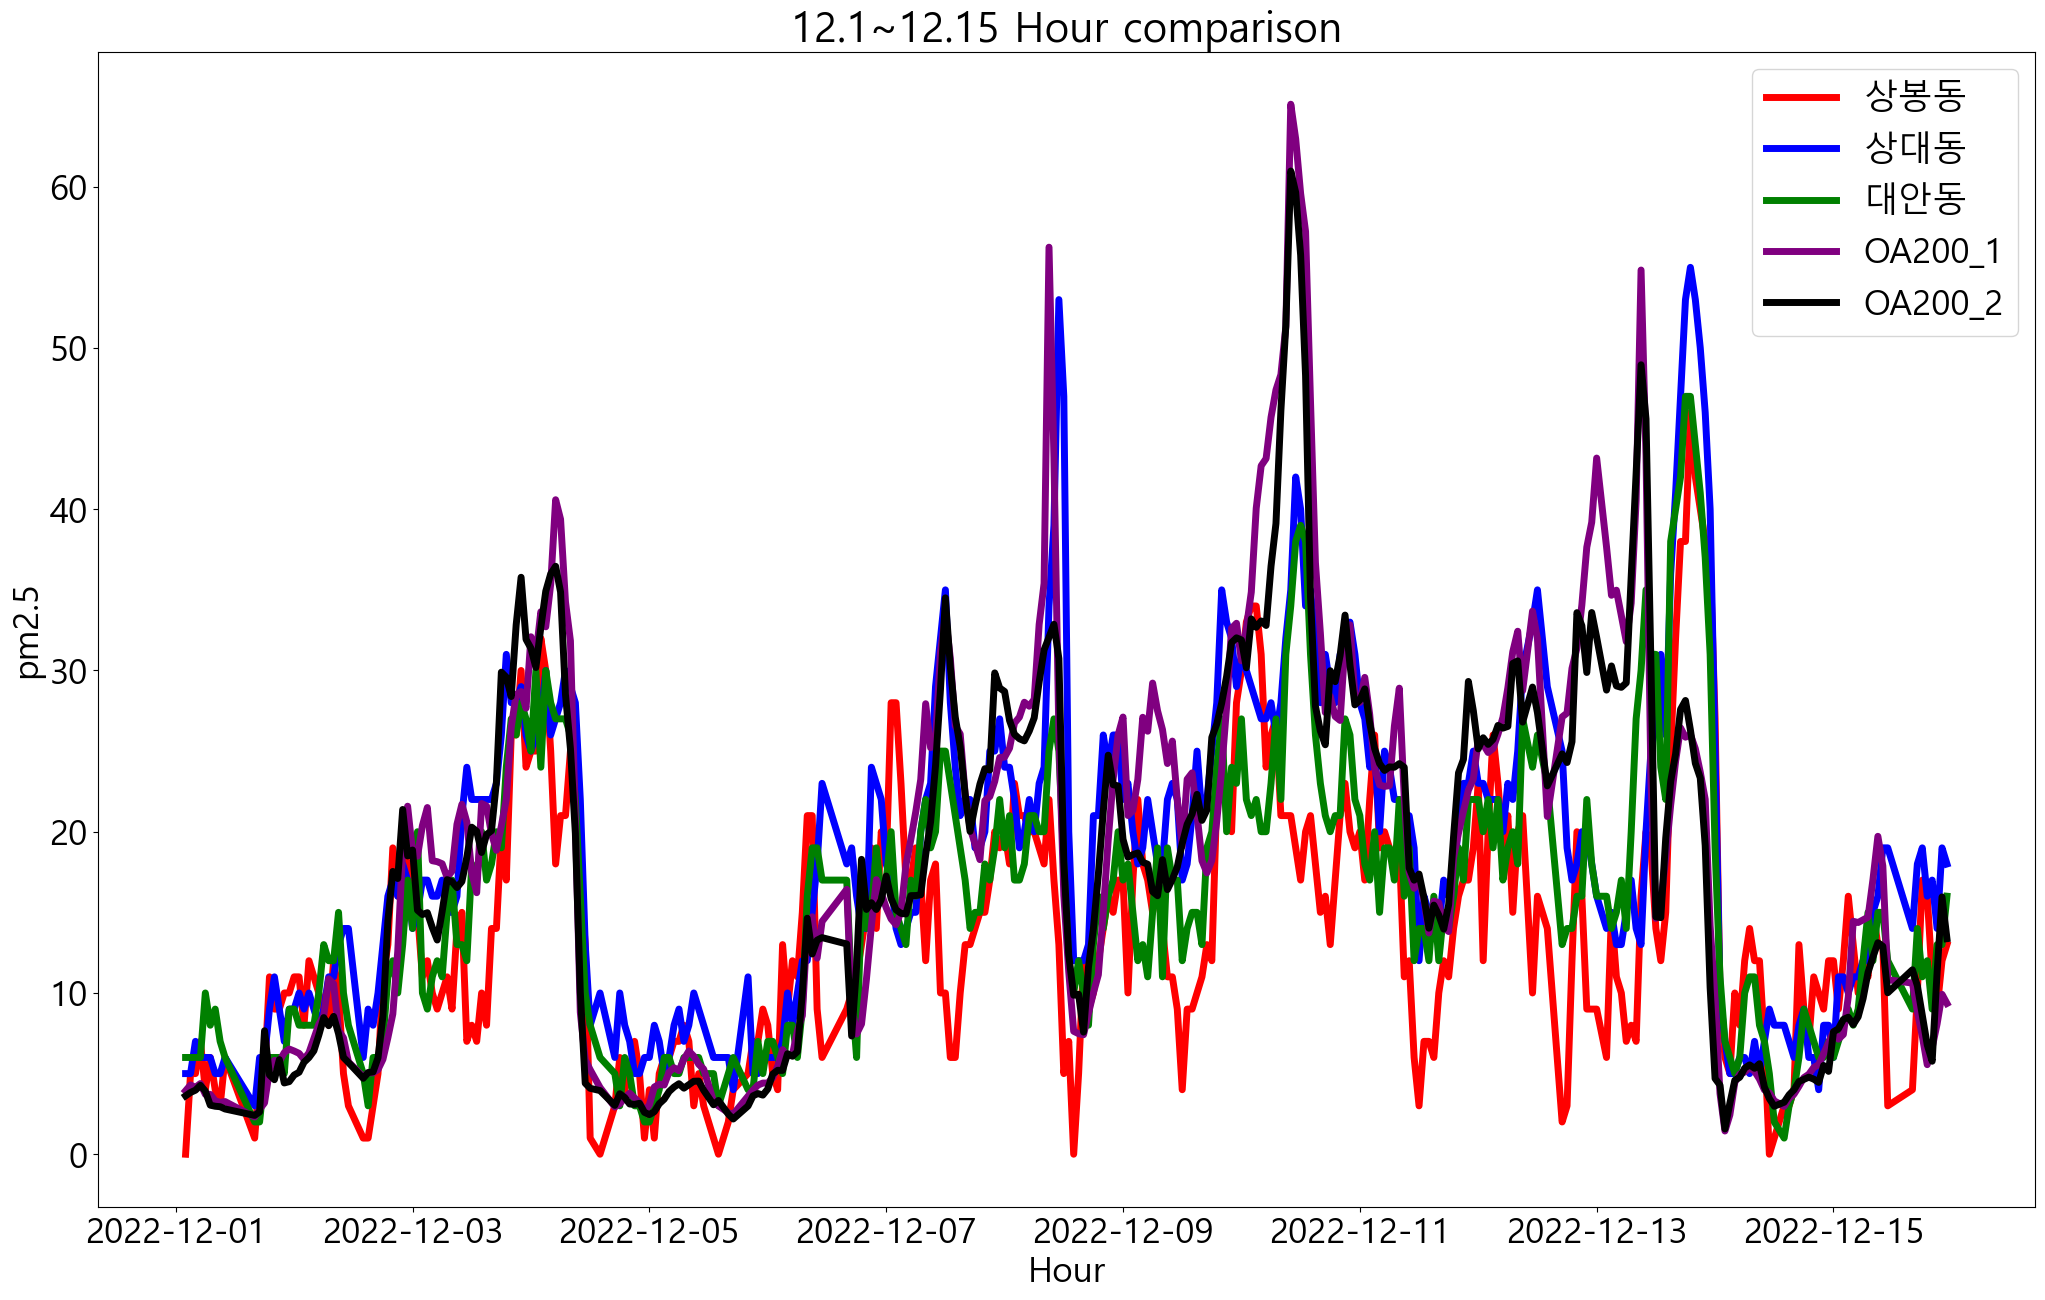

In [26]:
# 그래프 5개 비교
plt.plot(airKorea_data_1_avg.index, airKorea_data_1_avg.pm25, color="red", linewidth="5")
plt.plot(airKorea_data_2_avg.index, airKorea_data_2_avg.pm25, color="blue", linewidth="5")
plt.plot(airKorea_data_3_avg.index, airKorea_data_3_avg.pm25, color='green', linewidth="5")
plt.plot(OA200_1_avg.index, OA200_1_avg.pm25, color='purple', linewidth="5")
plt.plot(OA200_2_avg.index, OA200_2_avg.pm25, color='black', linewidth="5")
plt.xlabel('Hour')
plt.ylabel('pm2.5')
plt.legend(('상봉동','상대동','대안동','OA200_1','OA200_2'))
plt.title('12.1~12.15 Hour comparison')
plt.show()

C:\Users\ASUS\anaconda3\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


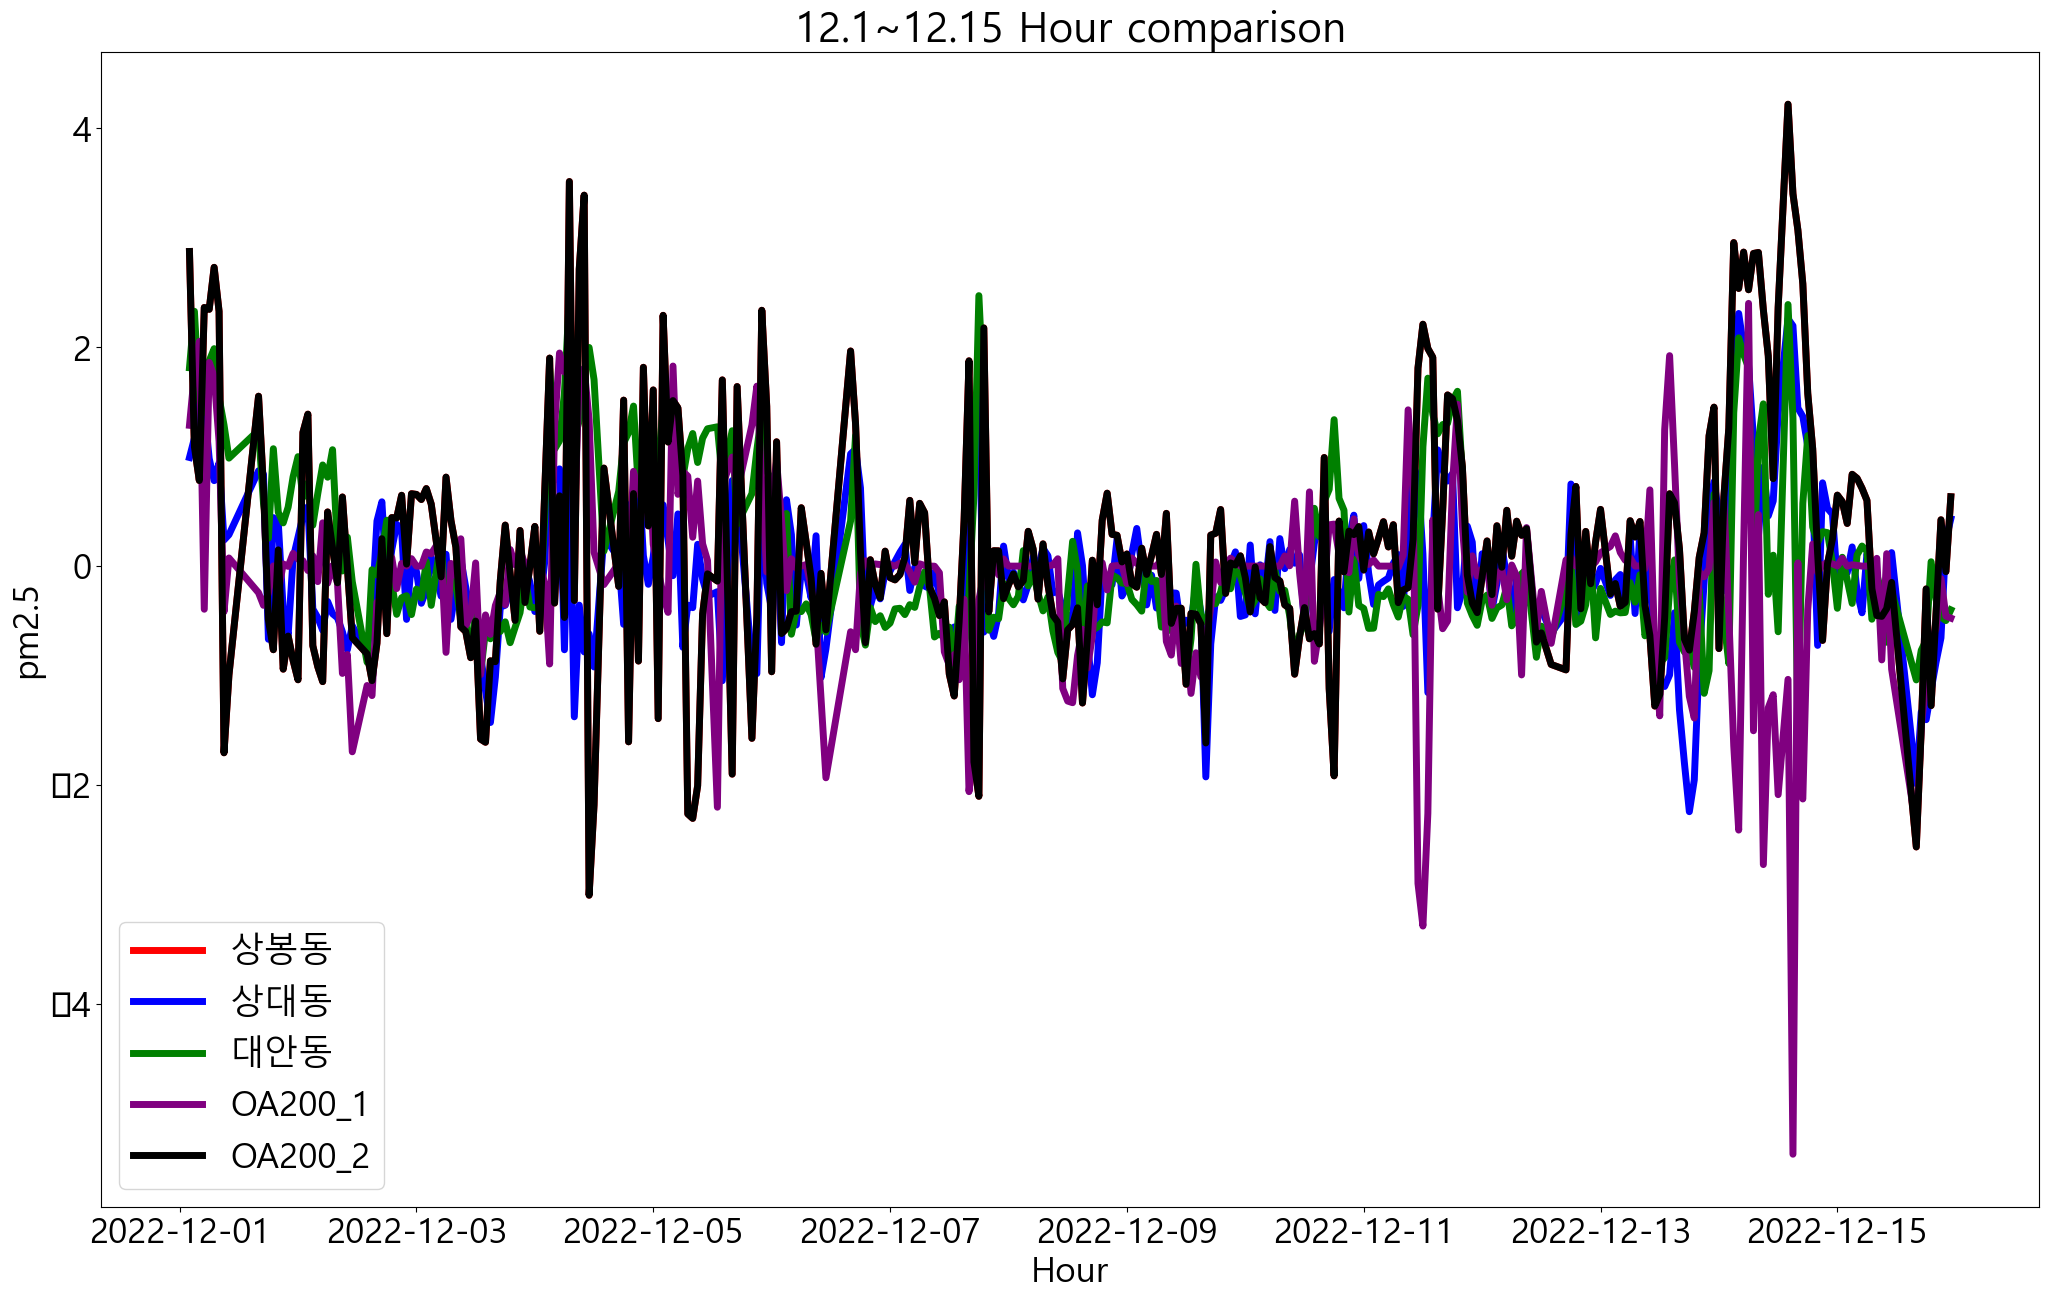

In [34]:
# 그래프 5개 비교
plt.plot(airKorea_data_1_avg.index, airKorea_data_1_avg.wind_vector_x, color="red", linewidth="5")
plt.plot(airKorea_data_2_avg.index, airKorea_data_2_avg.wind_vector_x, color="blue", linewidth="5")
plt.plot(airKorea_data_3_avg.index, airKorea_data_3_avg.wind_vector_x, color='green', linewidth="5")
plt.plot(OA200_1_avg.index, OA200_1_avg.wind_vector_x, color='purple', linewidth="5")
plt.plot(OA200_2_avg.index, OA200_2_avg.wind_vector_x, color='black', linewidth="5")
plt.xlabel('Hour')
plt.ylabel('pm2.5')
plt.legend(('상봉동','상대동','대안동','OA200_1','OA200_2'))
plt.title('12.1~12.15 Hour comparison')
plt.show()

-- 결론을 내자면   
arim 데이터의 pm2.5가 76이상인 데이터만 수정하고 ( -10.65 )   나머지는 그대로 둔 다음, 풍벡터(x,y), 온도, 습도 4가지 데이터를 통해 knn 모델(가장 단순한 모델)을 학습시켜 나쁨과 매우나쁨일 가능성이 큰 날을 알려주는 예측모델을 만드는 게 제일 밸런스가 있다.

모델을 만들어내는 데이터들이 너무 불안정해서 완전 정확한 값을 예측시키기가 어렵다.

# 그래도 한번 데이터 들이 들어오면 나온 값을 출력해주는 모델을 한번 만들어 보자

15일치의 데이터가 들어오면 예측은 할 수 있으니

In [ ]:
# 참고로 이 모델은 dataframe이 들어가야 하므로, csv파일을 수정할 필요가 있음. 사용자 입장을 생각하지 않은 모델이므로 수정과 수정을 거듭

class model :
    data_dict= {} # 데이터 프레임 저장 딕셔너리
    
    # outliar 제거 함수 (IQR 설정)
    def remove_out(*dataframes, remove_col) :
        for i, dataframe in enumerate(dataframes) :
            for k in remove_col :
                level_1q = dataframe[k].quantile(0.25)
                level_3q = dataframe[k].quantile(0.75)
                IQR = level_3q - level_1q
                rev_range = 10

                outliar_h = dataframe[k] >= level_3q + (rev_range * IQR)
                outliar_l = dataframe[k] <= level_1q - (rev_range * IQR)

                a=dataframe[outliar_h].index
                b=dataframe[outliar_l].index

                dataframe.drop(a, inplace=True)
                dataframe.drop(b, inplace=True)
                
    # 풍향과 풍속을 풍벡터로 표현
    def wind_vector(*dataframe):
        for data in dataframe :
            # 풍향을 라디안으로 변환
            theta = np.deg2rad(data.wind_dir)

            # 극 좌표에서 직교 좌표로 변환
            x = data.wind_speed * np.cos(theta)
            y = data.wind_speed * np.sin(theta)

            data['wind_vector_x'] = x
            data['wind_vector_y'] = y
            data.drop('wind_dir', axis=1, inplace=True)
            data.drop('wind_speed', axis=1, inplace=True)
    # 미세먼지 농도 라벨 설정
    def air_quality_label(pm25):
        if pm25 <= 35:
            return '좋음,보통'
        else:
            return '나쁨,매우 나쁨'
    
    # airKorea 데이터 가지고 예측
    def model_1(*dataframe) :
        count = 1 # 데이터 개수
        Flag = False # 데이터 개수가 달라 다시 시작
        while Flag == False :
            for data in dataframe : # 데이터들의 전처리 과정
                data.name = count
                remove_out(data, remove_col=['pm25'])
                # 1시간 단위로 측정 나누기
                data_avg = data.groupby([pd.Grouper(key='reg_date', freq='H')]).mean()
                # 좋음, 보통, 나쁨, 매우나쁨 카데고리 분류
                data_avg['air_quality_label'] = data_avg['pm25'].apply(lambda x: air_quality_label(x))
                # 참고로 Nan 값을 가진 pm2.5 데이터를 소거 해주는 작업이 필요!
                data_avg = data_avg.dropna(subset=['pm25'], axis=0)
                # 데이터를 저장
                data_dict[data_name] = data_avg
                count += 1
            # 가장 작은 data의 인덱스와 나머지 데이터들의 인덱스 같게 만들어주기
            if count == 2 :
                idx = set(data_dict[1].index).intersection(
                    set(data_dict[2].index)
                )
                data_dict[1].reindex(idx, inplace=True)
                data_dict[2].reindex(idx, inplace=True)
                # 풍벡터 삽입
                wind_vector(data_dict[1], dataframe[2])
                # index 정렬이 안되서 출력이 돼 그래프가 이상하게 그려져 적용시킴
                data_dict[1].sort_index(inplace=True)
                data_dict[2].sort_index(inplace=True)
            elif count == 3 :
                idx = set(data_dict[1].index).intersection(
                    set(data_dict[2].index),
                    set(data_dict[3].index)
                )
                data_dict[1].reindex(idx, inplace=True)
                data_dict[2].reindex(idx, inplace=True)
                data_dict[3].reindex(idx, inplace=True)
                # 풍벡터 삽입
                wind_vector(data_dict[1], data_dict[2], data_dict[3])
                # index 정렬이 안되서 출력이 돼 그래프가 이상하게 그려져 적용시킴
                data_dict[1].sort_index(inplace=True)
                data_dict[2].sort_index(inplace=True)
                data_dict[3].sort_index(inplace=True)
            elif count == 4 :
                idx = set(data_dict[1].index).intersection(
                    set(data_dict[2].index),
                    set(data_dict[3].index),
                    set(data_dict[4].index)
                )
                data_dict[1].reindex(idx, inplace=True)
                data_dict[2].reindex(idx, inplace=True)
                data_dict[3].reindex(idx, inplace=True)
                data_dict[4].reindex(idx, inplace=True)
                # 풍벡터 삽입
                wind_vector(data_dict[1], data_dict[2], data_dict[3], data_dict[4])
                # index 정렬이 안되서 출력이 돼 그래프가 이상하게 그려져 적용시킴
                data_dict[1].sort_index(inplace=True)
                data_dict[2].sort_index(inplace=True)
                data_dict[3].sort_index(inplace=True)
                data_dict[4].sort_index(inplace=True)
            elif count == 5 :
                idx = set(data_dict[1].index).intersection(
                    set(data_dict[2].index),
                    set(data_dict[3].index),
                    set(data_dict[4].index),
                    set(data_dict[5].index)
                )
                data_dict[1].reindex(idx, inplace=True)
                data_dict[2].reindex(idx, inplace=True)
                data_dict[3].reindex(idx, inplace=True)
                data_dict[4].reindex(idx, inplace=True)
                data_dict[5].reindex(idx, inplace=True)
                # 풍벡터 삽입
                wind_vector(data_dict[1], data_dict[2], data_dict[3], data_dict[4], data_dict[5])
                # index 정렬이 안되서 출력이 돼 그래프가 이상하게 그려져 적용시킴
                data_dict[1].sort_index(inplace=True)
                data_dict[2].sort_index(inplace=True)
                data_dict[3].sort_index(inplace=True)
                data_dict[4].sort_index(inplace=True)
                data_dict[5].sort_index(inplace=True)
            else :
                print("데이터의 개수를 2개에서 5개사이로 설정해주세요.")
                continue # 다시 시작
            

In [29]:
# arim_data 12.1~12.15 Hour
OA200_2 = pd.read_csv('./OA200_2/OA2002_12.01~12.15.csv')
OA200_1 = pd.read_csv('./OA200_1/OA2001_12.01~12.15.csv')
airKorea_data_3 = pd.read_csv('./AirKorea_대안동/AirKorea_12.01~12.15.csv')
OA200_1.name = "학교"
OA200_2.name = "진주성"
airKorea_data_3.name = "대안동"

# 풍향, 풍속 데이터
Sangbong = pd.read_csv("./weather/상봉동/2022-12.csv", encoding='cp949')
Jungchon = pd.read_csv("./weather/정촌면(학교근처)/2022-12.csv", encoding='cp949')
Daean = pd.read_csv("./weather/대안동/2022-12.csv", encoding='cp949')
Sangbong.name = "상봉동"
Jungchon.name = "정촌면"
Daean.name = "대안동"

data_list = [] # reindex를 하기 위한 리스트

# 풍향, 풍속 데이터 삽입
def wind_arim(*dataframe) :
    Flag = False
    while Flag == False :
        c = 0
        for data in dataframe :
            c += 1
            data['일시'] = data['일시'].apply(pd.to_datetime)
            data_avg = data.groupby([pd.Grouper(key='일시', freq='H')]).mean()
            if data.name == '상봉동' :
                for data2 in data_list :
                    if data2['name'] == 1 :
                        data2['data']['wind_dir'] = data_avg['풍향(16방위)']
                        data2['data']['wind_speed'] = data_avg['풍속(m/s)']
            elif data.name == "상대동" :
                continue
            elif data.name == "정촌면" :
                for data2 in data_list :
                    if data2['name'] == 0 :
                        data2['data']['wind_dir'] = data_avg['풍향(16방위)']
                        data2['data']['wind_speed'] = data_avg['풍속(m/s)']
            elif data.name == "대안동" :
                for data2 in data_list :
                    if data2['name'] == 2 :
                        data2['data']['temp'] = data_avg['기온']
                        data2['data']['humi'] = data_avg['상대습도(%)']
                        data2['data']['wind_dir'] = data_avg['풍향(16방위)']
                        data2['data']['wind_speed'] = data_avg['풍속(m/s)']
            else :
                print("현재 설정되지 않은 지역입니다.")
                continue
        if c == len(data_list) :
            Flag = True
# arim 데이터 reindex과정까지 규칙 진주성 = 1, 학교 = 0, 대안동 = 2
def model_1(*dataframe, wind_dataframe1 = None, wind_dataframe2 = None, wind_dataframe3 = None, wind_dataframe4 = None, wind_dataframe5 = None) :
    count = 0 # 데이터 개수
    Flag = False # 데이터 개수가 달라 다시 시작
    while Flag == False :
        for data in dataframe : # 데이터들의 전처리 과정
            if data.name == "학교" or data.name == "진주성" :
                print("#####\ndata_name =",data.name,"\n#####")
                # index를 datetime 형식으로 바꿔주기
                data['reg_date'] = data.reg_date.apply(pd.to_datetime)
                # 이름 설정
                data.name = int(input("지역 이름을 설정해 주세요 ex)학교=0,진주성=1,대안동=2 -> "))
                # 아웃라이어 제거
                remove_out(data, remove_col=['pm25'])
                # 1시간 단위로 측정 나누기
                data_avg = data.groupby([pd.Grouper(key='reg_date', freq='H')]).mean()
                # arim 데이터 수정
                data_76 = data_avg.loc[data_avg.loc[data_avg.pm25 >= 76].index]
                data_76.pm25 -= 10.65
                # arim 데이터 수정 후 대입
                data_avg.loc[data_76.index, 'pm25'] = data_76['pm25']
                # 좋음, 보통, 나쁨, 매우나쁨 카데고리 분류
                data_avg['air_quality_label'] = data_avg['pm25'].apply(lambda x: air_quality_label(x))
                # 참고로 Nan 값을 가진 pm2.5 데이터를 소거 해주는 작업이 필요!
                data_avg = data_avg.dropna(subset=['pm25'], axis=0)
                # 데이터를 저장
                data_list.append({'name': data.name, 'data': data_avg})
                count += 1
            else : # airKorea
                print("#####\ndata_name =",data.name,"\n#####")
                # index를 datetime 형식으로 바꿔주기
                data['date'] = data.date.apply(pd.to_datetime)
                # 이름 설정
                data.name = int(input("지역 이름을 설정해 주세요 ex)학교=0,진주성=1,대안동=2 -> "))
                # 아웃라이어 제거
                remove_out(data, remove_col=['pm25'])
                # 1시간 단위로 측정 나누기
                data_avg = data.groupby([pd.Grouper(key='date', freq='H')]).mean()
                data_avg.loc[data_76.index, 'pm25'] = data_76['pm25']
                # 좋음, 보통, 나쁨, 매우나쁨 카데고리 분류
                data_avg['air_quality_label'] = data_avg['pm25'].apply(lambda x: air_quality_label(x))
                # 참고로 Nan 값을 가진 pm2.5 데이터를 소거 해주는 작업이 필요!
                data_avg = data_avg.dropna(subset=['pm25'], axis=0)
                # 데이터를 저장
                data_list.append({'name': data.name, 'data': data_avg})
                count += 1
        # 가장 작은 data의 인덱스와 나머지 데이터들의 인덱스 같게 만들어주기
        if count == 2 :
            idx = set(data_list[0]['data'].index).intersection(
                set(data_list[1]['data'].index)
            )
            for data in data_list :
                data['data'] = data['data'].reindex(idx)
            Flag = True # 종료
        elif count == 3 :
            idx = set(data_list[0]['data'].index).intersection(
                set(data_list[1]['data'].index),
                set(data_list[2]['data'].index)
            )
            for data in data_list :
                data['data'] = data['data'].reindex(idx)
            Flag = True # 종료
        elif count == 4 :
            idx = set(data_list[0].index).intersection(
                set(data_list[1].index),
                set(data_list[2].index),
                set(data_list[3].index)
            )
            for data in data_list :
                data['data'] = data['data'].reindex(idx)
            Flag = True # 종료
        elif count == 5 :
            idx = set(data_list[0].index).intersection(
                set(data_list[1].index),
                set(data_list[2].index),
                set(data_list[3].index),
                set(data_list[4].index)
            )
            for data in data_list :
                data['data'] = data['data'].reindex(idx)
            Flag = True # 종료
    if count == 2 :
        wind_arim(wind_dataframe1, wind_dataframe2)
    elif count == 3 :
        wind_arim(wind_dataframe1, wind_dataframe2, wind_dataframe3)
    elif count == 4 :
        wind_arim(wind_dataframe1, wind_dataframe2, wind_dataframe3, wind_dataframe4)
    elif count == 5 :
        wind_arim(wind_dataframe1, wind_dataframe2, wind_dataframe3, wind_dataframe4, wind_dataframe5)

    for data in data_list :
        wind_vector(data['data'])
        
    # index 정렬이 안되서 출력이 돼 그래프가 이상하게 그려져 적용시킴
    for data in data_list :
        if data['name'] == 0 or data['name'] == 1 :
            data['data'].drop('no', axis=1, inplace=True)
        data['data'].sort_index(inplace=True)
        display(data['data'])
        
model_1(OA200_1, OA200_2, airKorea_data_3, wind_dataframe1=Sangbong, wind_dataframe2=Jungchon, wind_dataframe3=Daean)

#####
data_name = 학교 
#####
지역 이름을 설정해 주세요 ex)학교=0,진주성=1,대안동=2 -> 0
0 : [Int64Index([], dtype='int64'), Int64Index([], dtype='int64')] 

#####
data_name = 진주성 
#####


C:\Users\ASUS\AppData\Local\Temp\ipykernel_13952\1286017683.py:67: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data_avg = data.groupby([pd.Grouper(key='reg_date', freq='H')]).mean()


지역 이름을 설정해 주세요 ex)학교=0,진주성=1,대안동=2 -> 1


C:\Users\ASUS\AppData\Local\Temp\ipykernel_13952\1286017683.py:67: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data_avg = data.groupby([pd.Grouper(key='reg_date', freq='H')]).mean()


1 : [Int64Index([12405], dtype='int64'), Int64Index([], dtype='int64')] 

#####
data_name = 대안동 
#####
지역 이름을 설정해 주세요 ex)학교=0,진주성=1,대안동=2 -> 2
2 : [Int64Index([], dtype='int64'), Int64Index([], dtype='int64')] 



,pm25,pm10,temp,humi,air_quality_label,wind_vector_x,wind_vector_y
reg_date,,,,,,,
2022-12-01 01:00:00,3.533333,3.540000,2.940000,28.388333,"좋음,보통",2.585982,2.556959
2022-12-01 02:00:00,3.935000,3.951667,2.905000,30.986667,"좋음,보통",1.286737,2.116172
2022-12-01 03:00:00,4.295000,4.298333,2.880000,32.488333,"좋음,보통",1.759531,1.426281
2022-12-01 04:00:00,4.145000,4.158333,2.815000,33.360000,"좋음,보통",2.053407,1.971556
2022-12-01 05:00:00,4.381667,4.391667,2.896667,34.511667,"좋음,보통",-0.394081,3.489485
...,...,...,...,...,...,...,...
2022-12-15 19:00:00,5.555000,5.568333,8.423333,38.608333,"좋음,보통",-0.671827,-0.785128
2022-12-15 20:00:00,6.613333,6.625000,7.755000,41.756667,"좋음,보통",-0.574916,0.240866
2022-12-15 21:00:00,8.076667,8.091667,6.038333,48.183333,"좋음,보통",-0.114018,0.164316


,pm25,pm10,temp,humi,air_quality_label,wind_vector_x,wind_vector_y
reg_date,,,,,,,
2022-12-01 01:00:00,3.296667,3.318333,2.670000,28.361667,"좋음,보통",2.743724,-1.106216
2022-12-01 02:00:00,3.620000,3.645000,2.621667,31.176667,"좋음,보통",2.874943,-0.993197
2022-12-01 03:00:00,3.830000,3.858333,2.168333,33.126667,"좋음,보통",1.090252,-2.981942
2022-12-01 04:00:00,3.971667,4.003333,2.298333,33.828333,"좋음,보통",0.782081,-2.198362
2022-12-01 05:00:00,4.271667,4.293333,2.628333,34.906667,"좋음,보통",2.363239,-0.840737
...,...,...,...,...,...,...,...
2022-12-15 19:00:00,6.785000,6.791667,7.095000,42.246667,"좋음,보통",-1.274806,-0.022252
2022-12-15 20:00:00,5.766667,5.766667,7.103333,43.491667,"좋음,보통",-0.437336,-0.106005
2022-12-15 21:00:00,11.276667,11.318333,6.266667,46.393333,"좋음,보통",0.423347,-0.436860


,pm10,pm25,air_quality_label,temp,humi,wind_vector_x,wind_vector_y
date,,,,,,,
2022-12-01 01:00:00,15.0,6.0,"좋음,보통",-1.258333,35.000000,2.080421,1.038015
2022-12-01 02:00:00,11.0,6.0,"좋음,보통",-1.541667,39.500000,1.812784,1.009673
2022-12-01 03:00:00,13.0,6.0,"좋음,보통",-1.458333,40.833333,2.328644,1.018570
2022-12-01 04:00:00,14.0,6.0,"좋음,보통",-1.350000,41.500000,1.506734,0.922423
2022-12-01 05:00:00,15.0,6.0,"좋음,보통",-1.400000,44.333333,1.405496,0.729059
...,...,...,...,...,...,...,...
2022-12-15 19:00:00,60.0,12.0,"좋음,보통",4.091667,50.750000,0.039906,0.540195
2022-12-15 20:00:00,60.0,9.0,"좋음,보통",3.841667,52.666667,-0.301405,0.509141
2022-12-15 21:00:00,53.0,13.0,"좋음,보통",3.491667,56.000000,-0.466077,-0.156551


In [30]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import LabelEncoder


X_train = pd.concat([data_list[0]['data'], data_list[1]['data']])
X_train = X_train.drop(columns=['pm10','pm25' ,'air_quality_label'])
y_train = pd.concat([data_list[0]['data']['air_quality_label'], data_list[1]['data']['air_quality_label']]) # 현재는 2개만 설정

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# knn 적용
k = 5  # 이웃의 수를 5로 설정
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X_train, y_train)

# 예측을 수행 할 대상
X = data_list[2]['data'].drop(columns=['pm10','pm25', 'air_quality_label'])

y_pred = knn.predict(X) # 예측 수행
y_pred_proba = knn.predict_proba(X) # 각각의 데이터 포인트가 각 클래스에 속할 확률을 나타내는 2차원 배열

# 예측한 결과 출력
result = pd.DataFrame({'air_quality_label_pred': y_pred})
result.index = X.index
result['probability'] = np.max(y_pred_proba, axis=1)
display(result)

y = data_list[2]['data']['air_quality_label'].tolist() # 비교할 대상

result['air_quality_label'] = y
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(result)

# arim과 air이 같을때를 따로 찾아보기
mask = result['air_quality_label'] == result['air_quality_label_pred']
result_1 = result[mask]
result_1.dropna(inplace=True)

display(result_1)

# arim과 air이 다를때를 따로 찾아보기
mask = result['air_quality_label'] != result['air_quality_label_pred']
result_2 = result[mask]
result_2.dropna(inplace=True)

result_1.info()
result_2.info()

,air_quality_label_pred,probability
date,,
2022-12-01 01:00:00,"좋음,보통",1.0
2022-12-01 02:00:00,"좋음,보통",1.0
2022-12-01 03:00:00,"좋음,보통",1.0
2022-12-01 04:00:00,"좋음,보통",1.0
2022-12-01 05:00:00,"좋음,보통",1.0
...,...,...
2022-12-15 19:00:00,"좋음,보통",1.0
2022-12-15 20:00:00,"좋음,보통",1.0
2022-12-15 21:00:00,"좋음,보통",1.0


,air_quality_label_pred,probability,air_quality_label
date,,,
2022-12-01 01:00:00,"좋음,보통",1.0,"좋음,보통"
2022-12-01 02:00:00,"좋음,보통",1.0,"좋음,보통"
2022-12-01 03:00:00,"좋음,보통",1.0,"좋음,보통"
2022-12-01 04:00:00,"좋음,보통",1.0,"좋음,보통"
2022-12-01 05:00:00,"좋음,보통",1.0,"좋음,보통"
2022-12-01 06:00:00,"좋음,보통",1.0,"좋음,보통"
2022-12-01 07:00:00,"좋음,보통",1.0,"좋음,보통"
2022-12-01 08:00:00,"좋음,보통",1.0,"좋음,보통"
2022-12-01 09:00:00,"좋음,보통",1.0,"좋음,보통"


C:\Users\ASUS\AppData\Local\Temp\ipykernel_13952\3900030830.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_1.dropna(inplace=True)


,air_quality_label_pred,probability,air_quality_label
date,,,
2022-12-01 01:00:00,"좋음,보통",1.0,"좋음,보통"
2022-12-01 02:00:00,"좋음,보통",1.0,"좋음,보통"
2022-12-01 03:00:00,"좋음,보통",1.0,"좋음,보통"
2022-12-01 04:00:00,"좋음,보통",1.0,"좋음,보통"
2022-12-01 05:00:00,"좋음,보통",1.0,"좋음,보통"
...,...,...,...
2022-12-15 19:00:00,"좋음,보통",1.0,"좋음,보통"
2022-12-15 20:00:00,"좋음,보통",1.0,"좋음,보통"
2022-12-15 21:00:00,"좋음,보통",1.0,"좋음,보통"


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 300 entries, 2022-12-01 01:00:00 to 2022-12-15 23:00:00
Data columns (total 3 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   air_quality_label_pred  300 non-null    object 
 1   probability             300 non-null    float64
 2   air_quality_label       300 non-null    object 
dtypes: float64(1), object(2)
memory usage: 9.4+ KB
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 56 entries, 2022-12-03 18:00:00 to 2022-12-14 00:00:00
Data columns (total 3 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   air_quality_label_pred  56 non-null     object 
 1   probability             56 non-null     float64
 2   air_quality_label       56 non-null     object 
dtypes: float64(1), object(2)
memory usage: 1.8+ KB


C:\Users\ASUS\AppData\Local\Temp\ipykernel_13952\3900030830.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_2.dropna(inplace=True)


arim 데이터는 풍향,풍속만 넣으면 되고
airKorea 데이터는 기온, 습도, 풍향, 풍속 4개를 넣어야 함

In [12]:



# arim 데이터 풍향, 풍속 데이터 삽입



# airKorea 데이터 온도, 습도, 풍향, 풍속 데이터 삽입
airKorea_data_1_avg['temp'] = Sangbong_avg['기온']
airKorea_data_1_avg['humi'] = Sangbong_avg['상대습도(%)']
airKorea_data_1_avg['wind_dir'] = Sangbong_avg['풍향(16방위)']
airKorea_data_1_avg['wind_speed'] = Sangbong_avg['풍속(m/s)']

Sangdae = pd.read_csv("./weather/상대동/2023-01.csv", encoding='cp949')
Sangdae['일시'] = Sangdae['일시'].apply(pd.to_datetime)
Sangdae_avg = Sangdae.groupby([pd.Grouper(key='일시', freq='H')]).mean()
airKorea_data_2_avg['temp'] = Sangdae_avg['기온']
airKorea_data_2_avg['humi'] = Sangdae_avg['상대습도(%)']
airKorea_data_2_avg['wind_dir'] = Sangdae_avg['풍향(16방위)']
airKorea_data_2_avg['wind_speed'] = Sangdae_avg['풍속(m/s)']

Daean = pd.read_csv("./weather/대안동/2023-01.csv", encoding='cp949')
Daean['일시'] = Daean['일시'].apply(pd.to_datetime)
Daean_avg = Daean.groupby([pd.Grouper(key='일시', freq='H')]).mean()
airKorea_data_3_avg['temp'] = Daean_avg['기온']
airKorea_data_3_avg['humi'] = Daean_avg['상대습도(%)']
airKorea_data_3_avg['wind_dir'] = Daean_avg['풍향(16방위)']
airKorea_data_3_avg['wind_speed'] = Daean_avg['풍속(m/s)']



model_1(OA200_2, OA200_2)

display(data_dict[1])

NameError: name 'OA200_1_avg' is not defined